In [36]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import numpy as np

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
spark = SparkSession.builder.master('local').appName('Predicting Fire Dept Calls').config('spark.executor.memory','6gb').getOrCreate()

In [39]:
url = 'C:/Users/Dylan/Desktop/Datasets/csv_result-airlines.csv'
df = spark.read.format('com.databricks.spark.csv').options(header='True', inferschema='True').load(url)
df.show()

+---+-------+------+-----------+---------+---------+----+------+-----+
| id|Airline|Flight|AirportFrom|AirportTo|DayOfWeek|Time|Length|Delay|
+---+-------+------+-----------+---------+---------+----+------+-----+
|  1|     CO|   269|        SFO|      IAH|        3|  15|   205|    1|
|  2|     US|  1558|        PHX|      CLT|        3|  15|   222|    1|
|  3|     AA|  2400|        LAX|      DFW|        3|  20|   165|    1|
|  4|     AA|  2466|        SFO|      DFW|        3|  20|   195|    1|
|  5|     AS|   108|        ANC|      SEA|        3|  30|   202|    0|
|  6|     CO|  1094|        LAX|      IAH|        3|  30|   181|    1|
|  7|     DL|  1768|        LAX|      MSP|        3|  30|   220|    0|
|  8|     DL|  2722|        PHX|      DTW|        3|  30|   228|    0|
|  9|     DL|  2606|        SFO|      MSP|        3|  35|   216|    1|
| 10|     AA|  2538|        LAS|      ORD|        3|  40|   200|    1|
| 11|     CO|   223|        ANC|      SEA|        3|  49|   201|    1|
| 12| 

In [40]:
df = df.toPandas()
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [41]:
df = df.drop(['id'], axis=1)
df.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,269,SFO,IAH,3,15,205,1
1,US,1558,PHX,CLT,3,15,222,1
2,AA,2400,LAX,DFW,3,20,165,1
3,AA,2466,SFO,DFW,3,20,195,1
4,AS,108,ANC,SEA,3,30,202,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Airline      539383 non-null  object
 1   Flight       539383 non-null  int32 
 2   AirportFrom  539383 non-null  object
 3   AirportTo    539383 non-null  object
 4   DayOfWeek    539383 non-null  int32 
 5   Time         539383 non-null  int32 
 6   Length       539383 non-null  int32 
 7   Delay        539383 non-null  int32 
dtypes: int32(5), object(3)
memory usage: 22.6+ MB


In [43]:
df.describe()

,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,2427.928630,3.929668,802.728963,132.202007,0.445442
std,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,10.000000,0.000000,0.000000
25%,712.000000,2.000000,565.000000,81.000000,0.000000
50%,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,7814.000000,7.000000,1439.000000,655.000000,1.000000


In [44]:
df.shape

(539383, 8)

Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

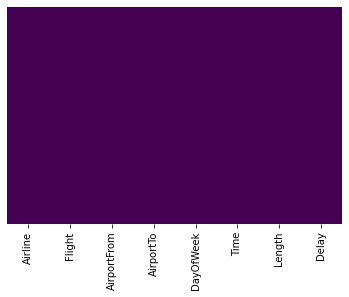

In [45]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
df.isnull().sum()

In [49]:
len(df)-len(df.drop_duplicates())

216618

0    299119
1    240264
Name: Delay, dtype: int64

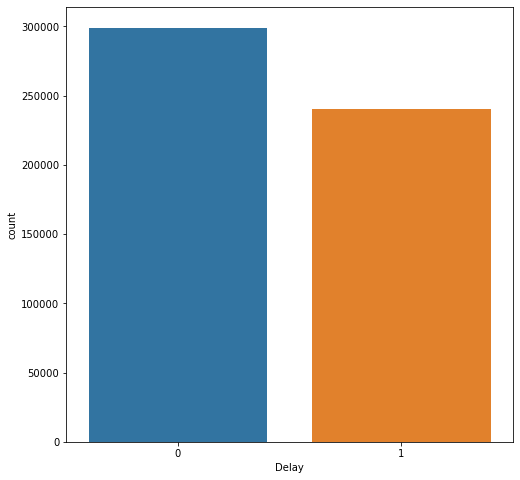

In [46]:
fig = plt.subplots(figsize=(8,8))
sns.countplot(x=df['Delay'])
df['Delay'].value_counts()

In [50]:
Airlines_Categorical = ['Airline','AirportFrom','AirportTo']
Airlines_Numerical = ['Flight','DayOfWeek','Time','Length']
Airlines_Targer = ['Delay']

In [70]:
totalNumber = len(df['AirportFrom'].value_counts())

print(df['AirportFrom'].value_counts())
print(f"Total Number of Airports to Depart From: {totalNumber}")

ATL    34449
ORD    24822
DFW    22154
DEN    19843
LAX    16657
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: AirportFrom, Length: 293, dtype: int64
Total Number of Airports to Depart From: 293


<AxesSubplot:ylabel='AirportFrom'>

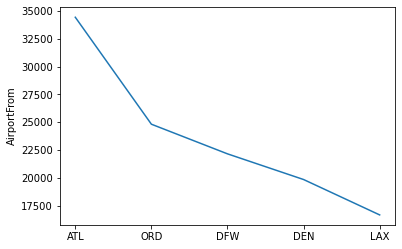

In [97]:
sns.lineplot(data=df['AirportFrom'].value_counts().nlargest(5))

In [69]:
totalNumber = len(df['AirportTo'].value_counts())

print(df['AirportTo'].value_counts())
print(f"Total Number of Airports to Depart To: {totalNumber}")

ATL    34440
ORD    24871
DFW    22153
DEN    19848
LAX    16656
       ...  
MMH       16
SJT       15
GUM       10
ADK        9
ABR        2
Name: AirportTo, Length: 293, dtype: int64
Total Number of Airports to Depart From: 293


WN    94097
DL    60940
OO    50254
AA    45656
MQ    36605
US    34500
XE    31126
EV    27983
UA    27619
CO    21118
FL    20827
9E    20686
B6    18112
YV    13725
OH    12630
AS    11471
F9     6456
HA     5578
Name: Airline, dtype: int64

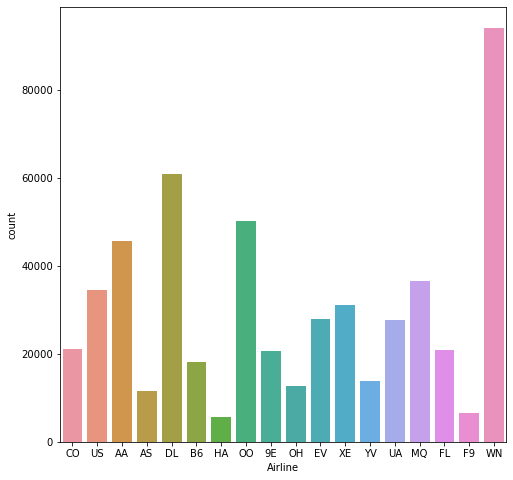

In [74]:
fig = plt.subplots(figsize=(8,8))
sns.countplot(x=df['Airline'])
df['Airline'].value_counts()

<AxesSubplot:>

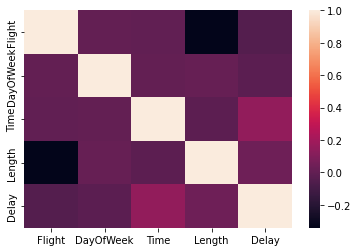

In [60]:
sns.heatmap(df.corr())